### PCA Comparisons

Dask-ML, Scikit-learn, and Scikit-allel

In [6]:
import allel
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sgkit.testing import simulate_genotype_call_dataset
from sklearn.decomposition import PCA as skPCA
from dask_ml.decomposition import PCA as daPCA
xr.set_options(display_style='text');

In [16]:
import dask.array as da
from dask_ml.decomposition import PCA
x = da.random.random(size=(100, 1000)).rechunk((-1, -1))
u, s, v = da.linalg.svd(x)

In [46]:
import dask.array as da
import numpy as np 
x = da.random.random(size=(1000, 100)).rechunk((-1, -1))

In [47]:
u, s, v = da.linalg.svd(x)
pcs1 = v.compute()
pcs1.shape

(100, 100)

In [48]:
vt, s, ut = da.linalg.svd(x.T)
pcs2 = vt.T.compute()
pcs2.shape

(100, 100)

In [50]:
all([
    np.allclose(pcs1[i], pcs2[i]) or 
    np.allclose(pcs1[i], -pcs2[i]) 
    for i in range(x.shape[1])
])

True

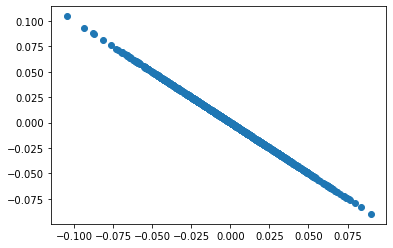

In [33]:
plt.scatter(pcs1[1], pcs2[:, 1])

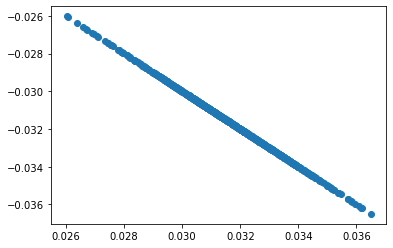

In [32]:
plt.scatter(pcs1[0], pcs2[:, 0])

In [14]:
import dask.array as da
from dask_ml.decomposition import PCA
x = da.random.random(size=(100, 1000)).rechunk((-1, 50))
#da.linalg.svd(x)
PCA(svd_solver='full').fit(x)

ValueError: Input must have the following properties:
  1. Have two dimensions
  2. Have only one column of blocks

Note: This function (tsqr) supports QR decomposition in the case of
tall-and-skinny matrices (single column chunk/block; see qr)Current shape: (100, 1000),
Current chunksize: (100, 50)

In [2]:
# Count non-reference alleles from simulated data
ds = simulate_genotype_call_dataset(n_variant=1000, n_sample=100)
gn = ds.call_genotype.sum(dim='ploidy')
gn.shape

(1000, 100)

In [3]:
gn[:5, :5]

<xarray.DataArray 'call_genotype' (variants: 5, samples: 5)>
array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 2],
       [1, 2, 1, 1, 2],
       [1, 2, 2, 1, 1],
       [2, 0, 2, 0, 1]])
Dimensions without coordinates: variants, samples

In [4]:
# Apply Patterson scaling to counts
def rescale(x, ploidy=2):
    mean = x.mean(dim='samples')
    p = mean / ploidy
    std = np.sqrt(p * (1 - p))
    return (x - mean) / std
gnr = rescale(gn).chunk(chunks=gn.shape)
gnr.shape

(1000, 100)

### Deterministic PCA

In [5]:
# Run Dask-ML PCA
pca = daPCA(n_components=2, svd_solver='full')
pcs1 = pca.fit(gnr.data.T).transform(gnr.data.T).compute()
pcs1.shape

ValueError: operands could not be broadcast together with shapes (1000,1000) (100,1) (1000,1000) 

In [6]:
# Run scikit-learn PCA
pca = skPCA(n_components=2, svd_solver='full')
pcs2 = pca.fit(np.asarray(gnr.data.T)).transform(np.asarray(gnr.data.T))
pcs2.shape

(100, 2)

In [7]:
# Run scikit-allel PCA
pcs3 = allel.pca(gn, n_components=2, scaler='patterson', ploidy=2)[0]
pcs3.shape

(100, 2)

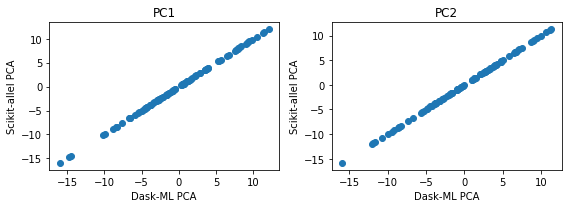

In [8]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((8, 3))
for i in range(2):
    axs[i].set_title(f'PC{i+1}')
    axs[i].scatter(pcs1[:, i], pcs3[:, i])
    axs[i].set_xlabel('Dask-ML PCA')
    axs[i].set_ylabel('Scikit-allel PCA')
plt.tight_layout()

In [9]:
np.testing.assert_allclose(pcs1[:, 0], pcs3[:, 0], atol=.1)
np.testing.assert_allclose(pcs1[:, 1], pcs3[:, 1], atol=.1)

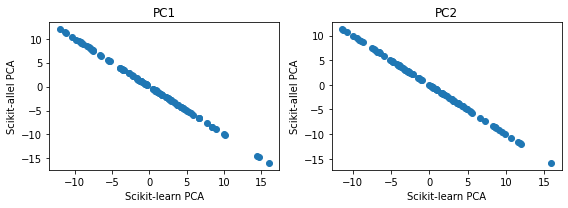

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((8, 3))
for i in range(2):
    axs[i].set_title(f'PC{i+1}')
    axs[i].scatter(pcs2[:, i], pcs3[:, i])
    axs[i].set_xlabel('Scikit-learn PCA')
    axs[i].set_ylabel('Scikit-allel PCA')
plt.tight_layout()

In [11]:
np.testing.assert_allclose(pcs2[:, 0], -pcs3[:, 0], atol=.1)
np.testing.assert_allclose(pcs2[:, 1], -pcs3[:, 1], atol=.1)

### Randomized PCA

In [14]:
# Run Dask-ML Randomized PCA
pca = daPCA(n_components=2, svd_solver='randomized', random_state=0, iterated_power=25)
pcs1 = pca.fit(gnr.data.T).transform(gnr.data.T).compute()
pcs1.shape

(100, 2)

In [15]:
# Run Scikit-allel Randomized PCA
pcs2 = allel.randomized_pca(gn, n_components=2, scaler='patterson', ploidy=2, random_state=0, iterated_power=25)[0]
pcs2.shape

(100, 2)

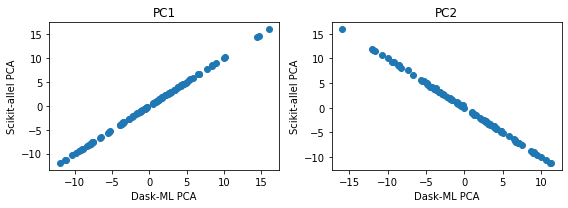

In [16]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((8, 3))
for i in range(2):
    axs[i].set_title(f'PC{i+1}')
    axs[i].scatter(pcs1[:, i], pcs2[:, i])
    axs[i].set_xlabel('Dask-ML PCA')
    axs[i].set_ylabel('Scikit-allel PCA')
plt.tight_layout()

In [17]:
np.testing.assert_allclose(pcs1[:, 0], pcs2[:, 0], atol=.5)
np.testing.assert_allclose(pcs1[:, 1], -pcs2[:, 1], atol=.5)